<a href="https://colab.research.google.com/github/Koussailakadi/Speech_Input_for_Emotion_Recognition/blob/main/emotion_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
print("path: ",os.getcwd())


%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
import numpy as np 
import pandas as pd


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split


path:  /content


In [3]:
#load data:
path_data=r"/content/drive/MyDrive/data.zip"

from zipfile import ZipFile
!unzip '/content/drive/MyDrive/data.zip'

Archive:  /content/drive/MyDrive/data.zip
   creating: data/
  inflating: data/Features.npy       
  inflating: data/labels.npy         


In [4]:
try:
  del Features
  del Labels
  del x_train
  del x_test
  del y_train
  del y_test
except:
  pass
  
Features=np.load("/content/data/Features.npy")
Labels=np.load("/content/data/labels.npy")

In [5]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Labels = encoder.fit_transform(np.array(Labels).reshape(-1,1)).toarray()
print(Labels.shape)
print(Features.shape)

(3170, 2)
(3170, 80000)


In [6]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(Features, Labels, random_state=0, shuffle=True)
print("x_train:{} , y_train:{} , x_test:{} ,y_test:{}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train:(2377, 80000) , y_train:(2377, 2) , x_test:(793, 80000) ,y_test:(793, 2)


In [7]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
print("x_train:{} , y_train:{} , x_test:{} ,y_test:{}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train:(2377, 80000) , y_train:(2377, 2) , x_test:(793, 80000) ,y_test:(793, 2)


In [8]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)

y_train = np.expand_dims(y_train, axis=1)
y_test = np.expand_dims(y_test, axis=1)
print("x_train:{} , y_train:{} , x_test:{} ,y_test:{}".format(x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train:(2377, 80000, 1) , y_train:(2377, 1, 2) , x_test:(793, 80000, 1) ,y_test:(793, 1, 2)


In [9]:
import sys
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Model
from keras.layers import Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Activation , Add , Input, TimeDistributed, GlobalAveragePooling1D
from keras.callbacks import ModelCheckpoint
from keras import activations

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 


#Résidual bloc:
def block(inputs, filters, kernel_size, strides):
    #apply conv1D:
    fx = Conv1D(filters, kernel_size, strides , padding='same')(inputs)

    #apply a batchnormalization to an input tensor:
    fx = BatchNormalization()(fx)
    
    #apply a rulu functgion to batch normalized tensor
    fx = Activation(activations.relu)(fx)
     
    return fx


#Résidual blocs:
def resnet_block(inputs, filters, kernel_size=3, stride=3):
    #bloc 1:
    fx = block(inputs, filters, kernel_size, strides=stride)
    
    #bloc 2:
    fx = block(fx, filters, kernel_size, strides=1)
    
    #bloc 3:
    fx = block(fx, filters, kernel_size, strides=1)
    
    #skip connection:
    skip_x = Conv1D(filters, kernel_size, strides=stride , padding ='same')(inputs)

    #apply a batchnormalization to an input tensor:
    skip_x = BatchNormalization()(skip_x)
    
    #add layer:
    out= Add()([fx,skip_x])
    
    #relu:
    out = Activation(activations.relu)(out)
        
    return out



def Resnet(input_shape=(80000,1)):
    
    x_input=Input(shape=input_shape)
    #stag 1:
    x=Conv1D(filters=128, kernel_size=3, strides=3)(x_input)
    x=BatchNormalization()(x)
    x=Activation(activations.relu)(x)

    #resnets blocs:
    x=resnet_block(x, filters=128, kernel_size=3, stride=3)
    x=resnet_block(x, filters=256, kernel_size=3, stride=3)
    x=resnet_block(x, filters=256, kernel_size=3, stride=3)
    x=resnet_block(x, filters=256, kernel_size=3, stride=3)
    x=resnet_block(x, filters=512, kernel_size=3, stride=3)
    x=resnet_block(x, filters=512, kernel_size=3, stride=3)
    x=resnet_block(x, filters=512, kernel_size=3, stride=3)
    
    #conv2:
    x=Conv1D(filters=768, kernel_size=3, strides=1)(x)
    x=BatchNormalization()(x)
    x=Activation(activations.relu)(x)
    
    #dense layers: 
    x=Dropout(rate=0.5, noise_shape=None)(x)
    dense_layer_1=Dense(768,activation=activations.relu)
    x=TimeDistributed(dense_layer_1)(x)
    dense_layer_2=Dense(2)
    x=TimeDistributed(dense_layer_2)(x)
    x=GlobalAveragePooling1D(keepdims=True)(x)
    x=Activation(activations.softmax)(x)
    #model
    model= Model(x_input, x, name='Rasnet')
    
    return model
  
#inputs:
inputs=x_train.shape
model=Resnet()

# initiate Adam optimizer
opt = keras.optimizers.Adam(learning_rate=0.01)

# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

model.summary()

Model: "Rasnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80000, 1)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 26666, 128)   512         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 26666, 128)  512         ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 26666, 128)   0           ['batch_normalization[0][0]'

In [10]:
epochs=10
batch_size=32

# Fit the model
history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test,y_test),
              shuffle=True)
              
print("fin d'entrainement")

Epoch 1/10
75/75 [==============================] - 139s 2s/step - loss: 0.4464 - accuracy: 0.7535 - val_loss: 0.3546 - val_accuracy: 0.8714
Epoch 2/10
75/75 [==============================] - 118s 2s/step - loss: 0.1454 - accuracy: 0.9466 - val_loss: 0.6218 - val_accuracy: 0.8222
Epoch 3/10
75/75 [==============================] - 118s 2s/step - loss: 0.0873 - accuracy: 0.9676 - val_loss: 0.1875 - val_accuracy: 0.9433
Epoch 4/10
75/75 [==============================] - 118s 2s/step - loss: 0.0781 - accuracy: 0.9684 - val_loss: 0.1893 - val_accuracy: 0.9445
Epoch 5/10
75/75 [==============================] - 118s 2s/step - loss: 0.0746 - accuracy: 0.9756 - val_loss: 0.6386 - val_accuracy: 0.8272
Epoch 6/10
75/75 [==============================] - 118s 2s/step - loss: 0.0513 - accuracy: 0.9823 - val_loss: 0.3250 - val_accuracy: 0.9130
Epoch 7/10
75/75 [==============================] - 118s 2s/step - loss: 0.0453 - accuracy: 0.9870 - val_loss: 0.5691 - val_accuracy: 0.8638
Epoch 8/10
75

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


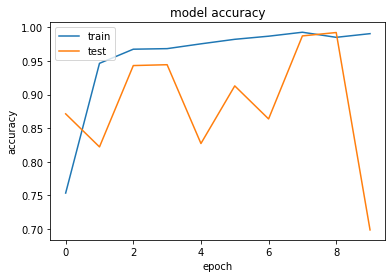

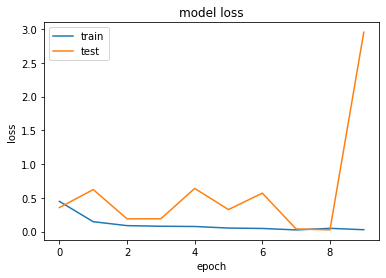

In [11]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
model.save('/content/drive/MyDrive/my_model.h5')  # creates a HDF5 file 'my_model.h5'

del model  # deletes the existing model

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [13]:
from keras.models import load_model
model = load_model('/content/drive/MyDrive/my_model.h5')

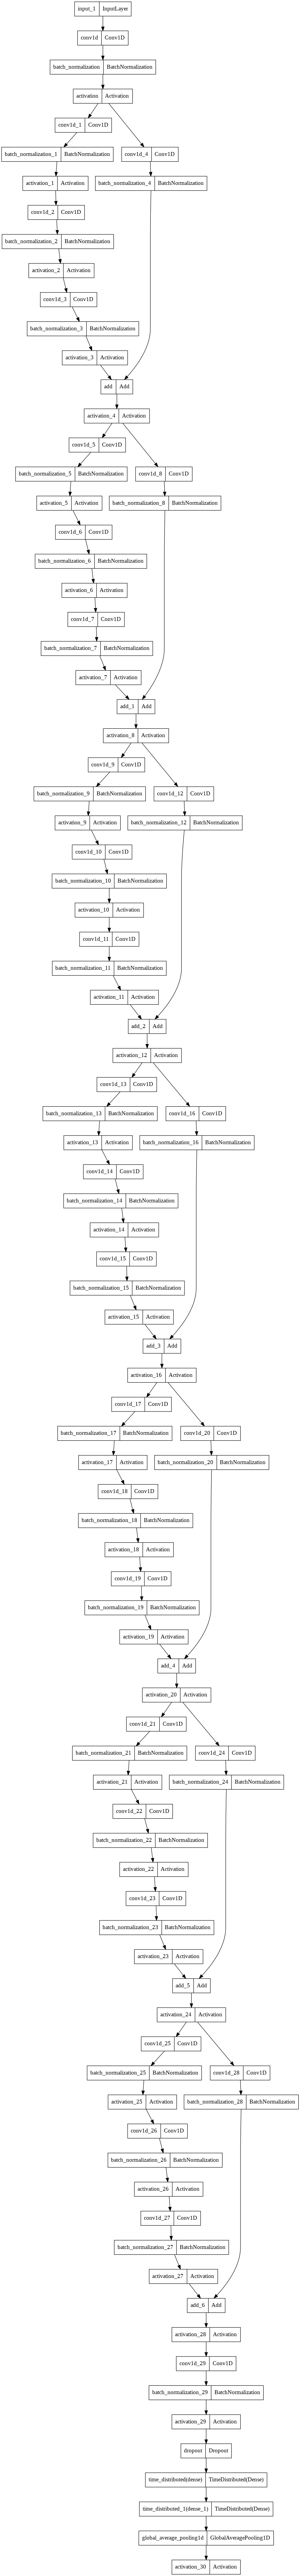

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
)